**Installing Packages** 

In [43]:
# Installing yfinance

%pip install yfinance

# Importing Libraries
import numpy as np 
import pandas as pd
import yfinance as yf
import datetime as dt
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Note: you may need to restart the kernel to use updated packages.


**Importing data from yfinance**

1. Defining function

In [44]:
# Create a function that gets all option expirations and loops through to get chains
# Combines each option chain into a dataframe and compute time-to-expiration

def option_chains(ticker): 
    asset = yf.Ticker(ticker) 
    expirations = asset.options
    chains = pd.DataFrame()
    for expiration in expirations:
        opt = asset.option_chain(expiration)
        calls = opt.calls 
        calls["optionType"] = "call"
        puts = opt.puts
        puts["optionType"] = "put"
        chain = pd.concat([calls, puts])
        chain["expiration"] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59)
        chains = pd.concat([chains, chain])
    chains["daysToExpiration"] = (chains.expiration - dt.datetime.today()).dt.days + 1
    return chains

2. Specifying what data we want from the option chain

In [85]:
# Download data for e.g. call options on the VOO ETF
options = option_chains("VOO")
calls = options[options["optionType"]=="call"]
puts = options[options["optionType"]=="put"]

# show expirations
set(calls.expiration)
set(puts.expiration)

# Choose expiry date to plot
calls_at_expiry = calls[calls["expiration"] == "2023-04-21 23:59:59"]

# Remove low volatilities
filtered_calls_at_expiry = calls_at_expiry[calls_at_expiry.impliedVolatility >= 0.01]

# Printing our data

print(calls)

        contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0   VOO230421C00170000 2023-03-23 19:44:51+00:00   170.0     192.40  207.20   
1   VOO230421C00190000 2023-03-23 19:58:50+00:00   190.0     173.23  187.20   
2   VOO230421C00200000 2023-03-24 18:48:15+00:00   200.0     163.00  177.30   
3   VOO230421C00205000 2022-12-20 15:06:59+00:00   205.0     147.60  153.50   
4   VOO230421C00215000 2022-12-01 15:00:05+00:00   215.0     163.50  136.70   
..                 ...                       ...     ...        ...     ...   
57  VOO250117C00540000 2022-12-20 19:36:54+00:00   540.0       2.70    0.95   
58  VOO250117C00545000 2022-10-13 16:51:41+00:00   545.0       3.40    3.80   
59  VOO250117C00550000 2023-04-13 17:40:58+00:00   550.0       1.09    1.10   
60  VOO250117C00555000 2023-01-30 14:35:29+00:00   555.0       2.50    0.00   
61  VOO250117C00565000 2023-03-13 15:13:46+00:00   565.0       0.93    0.60   

      ask  change  percentChange  volume  openInter

In [36]:
# Plot implied volatility term structure
calls_at_strike = options[options["strike"] == 375]

# Remove low volatilities
filtered_calls_at_strike = calls_at_strike[calls_at_strike.impliedVolatility >= 0.001]

3. Making the plot 

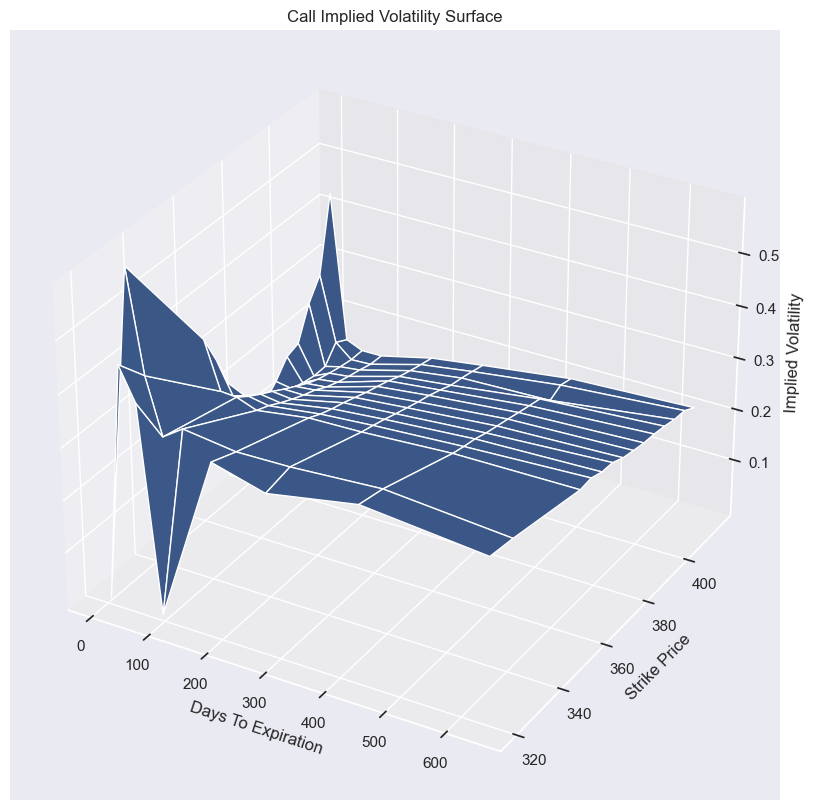

In [37]:
# Plots the implied volatility surface

surface = (
    calls[['daysToExpiration', 'strike', 'impliedVolatility']]
    .pivot_table(values='impliedVolatility', index='strike', columns='daysToExpiration')
    .dropna()
)

# Create figure object 
fig = plt.figure(figsize=(20, 10))

# Adds subplot with projection
ax = fig.add_subplot(111, projection='3d')

# gets values from dataframe
x, y, z = surface.columns.values, surface.index.values, surface.values
X, Y = np.meshgrid(x, y)

# Sets labels
ax.set_xlabel("Days To Expiration")
ax.set_ylabel("Strike Price")
ax.set_zlabel("Implied Volatility")
ax.set_title("Call Implied Volatility Surface")

ax.plot_surface(X, Y, z)

**Making a plot of S&P 500 vs the VIX**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'The Price of SP 500 vs The VIX')

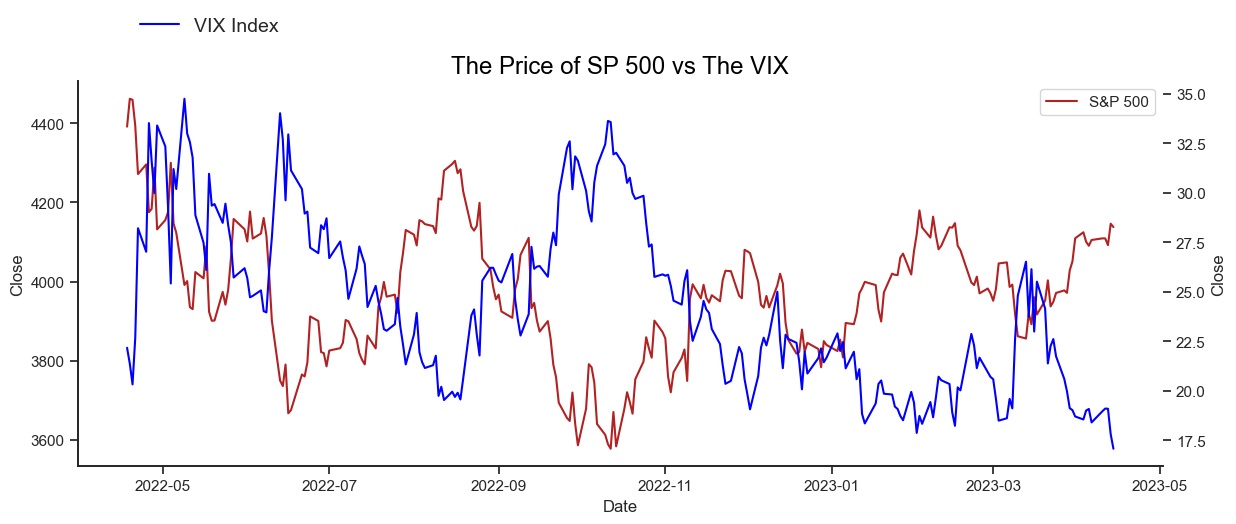

In [38]:

# Defining time period

Start = date.today() - timedelta(365)
Start.strftime('%Y-%m-%d')

End = date.today() + timedelta(2)
End.strftime('%Y-%m-%d') 

# Defining function that donwloads the closing price of a specific ticker

def closing_price(ticker):
    Asset = pd.DataFrame(yf.download(ticker, start=Start,
      end=End))     
    return Asset

SP = closing_price('^GSPC') # Setting variable for S&P 500
SP.reset_index(inplace=True) 

VIX = closing_price('^VIX') # Setting variable for VIX
VIX.reset_index(inplace=True)

# Creating plot

plt.figure(figsize=(14,5))
sns.set_style("ticks")
sns.lineplot(data=SP,x="Date",y='Close',color='firebrick', label='S&P 500')
ax2 = plt.twinx()
sns.lineplot(data=VIX,x="Date",y='Close',color='blue', label='VIX Index', ax=ax2)
sns.despine()
plt.legend(loc=(0.05,1.1),ncol=2,frameon=False, prop={'size': 14})
plt.title("The Price of SP 500 vs The VIX",size='x-large',color='black')

**Conclusion**

While the implied volatility seems to be correlated with the actual volatility, it doesn't seem to be that good of a measure in predicting future volatility. Hence, it might not be as valuable for traders and investors in determining asset exposure and risk management. It is however something worth noting when examining if options are correctly priced. 